# Who did waht to Whom

This is analysis code for both `main experiment` and `further study about individuation`. 
We also provid a '.html' version in the same fold.
- note: we suppressed some friendly warning messages. You can remove the code if you want to know more information.

In [3]:
library(ggplot2)
library(readxl)
library(dplyr)
library(lmerTest)
library(tidyr)
library(ggpubr)
library(purrr)

In [15]:
options(dplyr.summarise.inform = FALSE) # avoid the Message about "You can override using the `.groups` argument"
options(warn = -1) # supress warning messages

## functions

In [4]:
plot_fun <- function(df, level, class){
    p <- ggplot(df, aes(x = factor(Condition,levels = level), y = Mean, color = class, group = class))  +
            geom_point(size = 2.5)+ geom_line(size= 1) + theme_bw() + 
            theme(axis.text.x = element_text(size=18,color = "black", angle = 15), 
              axis.title.x = element_blank(),
              axis.text.y = element_text(size=18,color = "black"),  
              axis.title.y = element_text(size = 18, color = "black"),
              legend.text = element_text(size= 18), 
              legend.title=element_blank(),
              aspect.ratio = 4/10) 
    return(p)
}

In [5]:
fun_lmer <- function(df){
    lm_result <- lmer(Value ~ BABEI + (1| Verb), data= df)
    return(data.frame(estimate_bei = summary(lm_result)$coefficients[2,1],
                     p_value = summary(lm_result)$coefficients[2,5]));
}

In [6]:
lmer_table <- function(df, Level){    
    df_table <- df %>% 
        mutate(p = case_when(p_value >= 0.06 ~ "not_sig",
                             p_value < 0.06 & p_value >= 0.05 ~ "_marginal",
                              p_value < 0.05 & p_value > 0.01 ~ "*",
                              p_value <= 0.01 & p_value > 0.001 ~ "**",
                              TRUE ~ "***")) %>%
        mutate(pref = case_when(estimate_bei > 0 ~ "ba",TRUE ~ "bei")) %>%
        mutate(pref_p = paste(pref,p)) %>% 
        select(-estimate_bei, -p_value, -p, -pref)%>%
        spread(model, pref_p) %>%
        arrange(factor(Condition, level = Level))
   
    return(df_table)
}

condition_all <- c("atelic", 'telic', 'do', 'happen', 'aim', 'non-volition', 'volition','NP2_com', 'NP1_com')
condition_tel <- c('temporal', 'spatial')
condition_ind = c("P/P","C_cl/C_cl","C_cl/P", "P/C_cl" , "C/P")
model_order <- c('Condition','BERT-base', 'RoBERTa-base','ELECTRA-large','ERNIE 1.0', 'MacBERT-base', 'MacBERT-large')

## read model results (Surp) from the fold 'main_experiment':

In [34]:
# read data

file_list <- list.files(path = "C:/Work/Mypaper_BABEI/Github/main_Experiment", 
                        pattern='^Result_', full.names = TRUE)
file_list <-  file_list[-4] # remove the human results
file_name_list <- setNames(file_list, file_list) # need an id-column with the file-names

suppressMessages(df_model_raw <- map_df(file_name_list, read_excel, .id = "id")%>% 
                            separate(id, c(NA, "model"), "Result_")
)

In [8]:
# preprocess the data
df_model <- df_model_raw %>% 
        mutate(model = recode(model,'bert_base.xlsx' = "BERT-base",
                                 'roberta_base.xlsx' = 'RoBERTa-base',
                                 'electra_large.xlsx'= 'ELECTRA-large',
                                 'ernie.xlsx'        = 'ERNIE 1.0', 
                                 'macbert_base.xlsx' = 'MacBERT-base', 
                                 'macbert_large.xlsx' = 'MacBERT-large'))%>%
        select(-MaskedSentence) %>% 
        separate(Verb, c("telic", "Verb")) %>%
        mutate(ba = -log(df_model_raw$prob_ba+exp(-30), base = 2),
               bei = -log(df_model_raw$prob_bei+exp(-30), base = 2)) %>%
        mutate(diff_babei = ba - bei, telic = case_when(telic == 's' ~ 'spatial',TRUE ~ 'temporal'))

print(unique(df_model$Condition))
print(unique(df_model$model))

[1] "volition"     "non-volition" "do"           "happen"       "NP2_com"     
[6] "telic"        "atelic"       "NP1_com"      "aim"         
[1] "BERT-base"     "ELECTRA-large" "ERNIE 1.0"     "MacBERT-base" 
[5] "MacBERT-large" "RoBERTa-base" 


## read human results (Accep) from the fold 'main_experiment':

In [9]:
df_read_hum <- read_excel("Result_human.xlsx") %>%
        select(-List, -Items) %>%
        separate(Verb, c("telic", "Verb")) 

df_hum_filler <- df_read_hum %>% 
        filter(telic == "x") %>% # select the filler items
        group_by(Participant) %>% 
        summarise(Mean = mean(Value))%>%
        filter(Mean < 3.5) # particpants whose judgment value mean < 3.5 

# remove participants whose judgment value mean < 3.5
df_hum <- df_read_hum %>%
        filter(telic != "x" & !Participant %in% as.list(df_hum_filler$Participant)) %>%
        mutate(telic = case_when(telic == 's' ~ 'spatial',
                                 TRUE ~ 'temporal'))

## Coefficient of variation (average Accep/Surp) of each condition

In [10]:
cv_mod <- df_model %>% 
        gather(BABEI,Surp, ba:bei) %>%
        group_by(BABEI,Condition) %>%
        summarize(Mean = sd(Surp)/mean(Surp)) 

cv_hum <- df_hum %>% 
        group_by(BABEI, Condition)%>% 
        summarise(Mean = sd(Value)/mean(Value))

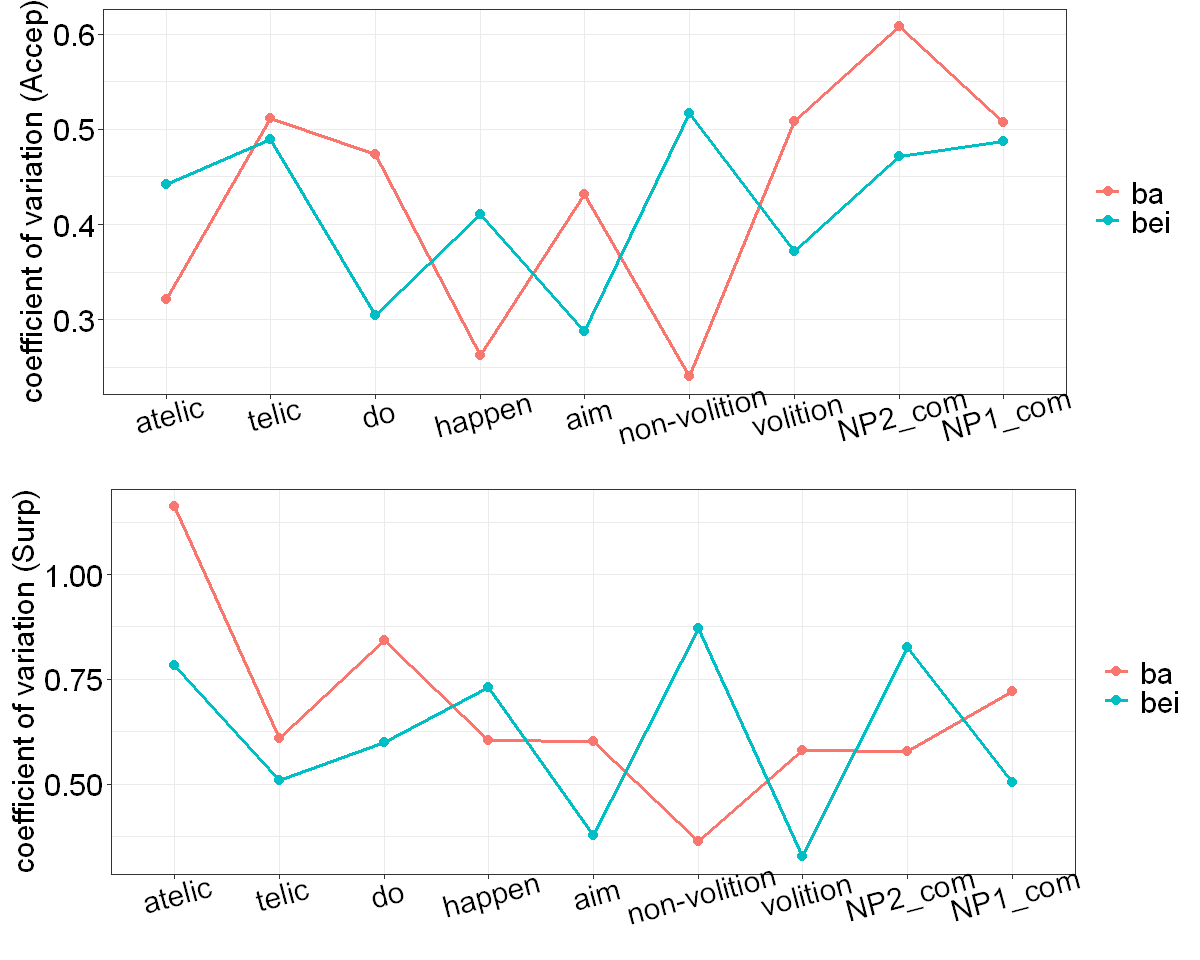

In [11]:
options(repr.plot.width= 10, repr.plot.height=8)

p1 <- plot_fun(cv_hum,condition_all, cv_hum$BABEI) +
        labs(y = "coefficient of variation (Accep)") 

p2 <- plot_fun(cv_mod,condition_all, cv_mod$BABEI) +
        labs(y = "coefficient of variation (Surp)") 

ggarrange(p1, p2, ncol= 1, nrow = 2)

## average B_hum and average B_LMs

In [12]:
sum_hum_ba <- df_hum %>% filter(BABEI == "ba") %>% group_by(Verb, Condition)%>% summarise(ba_mean = mean(Value))
sum_hum_bei <- df_hum %>% filter(BABEI == "bei") %>% group_by(Verb, Condition)%>% summarise(bei_mean = mean(Value))

B_hum <- sum_hum_ba %>% 
        right_join(sum_hum_bei, by=c("Verb","Condition")) %>% 
        mutate(diff_babei = ba_mean - bei_mean)  %>% 
        group_by(Condition)%>% 
        summarise(Mean = mean(diff_babei)) %>% 
        mutate(class = "same-color")

B_mod <- df_model %>% 
        group_by( Condition, model) %>% 
        summarise(Mean = mean(diff_babei))

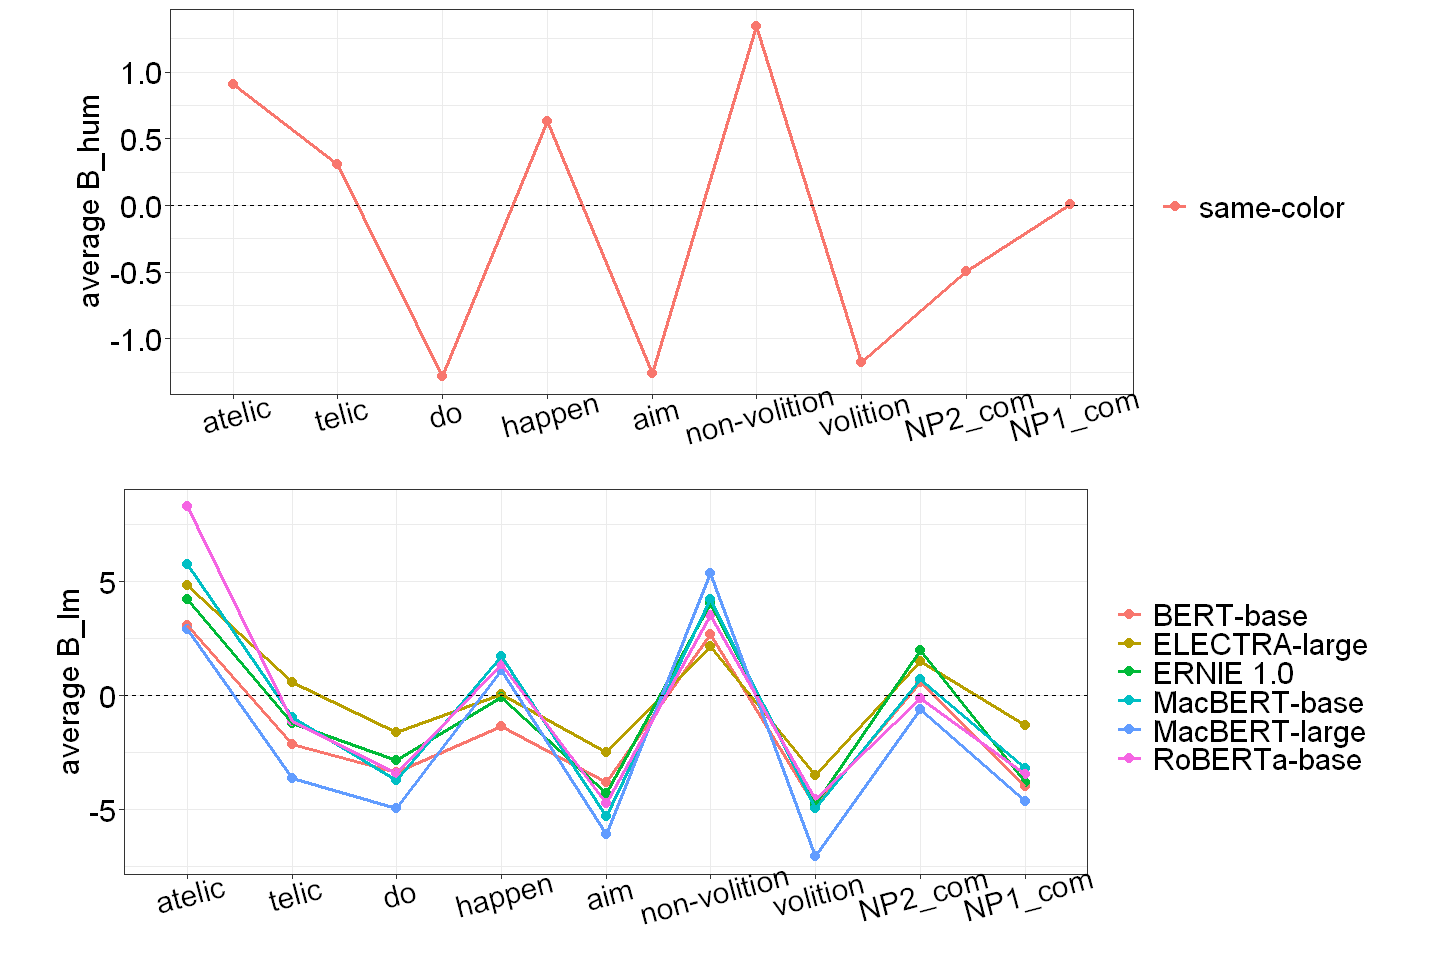

In [16]:
options(repr.plot.width= 12, repr.plot.height=8)

p1 <- plot_fun(B_hum, condition_all, B_hum$class) +
        geom_line(aes(group = as.numeric(Condition), size= 1), size = 1) +
        geom_hline(aes(yintercept = 0), linetype="dashed") +
        labs(y = "average B_hum") 

p2 <- plot_fun(B_mod, condition_all, B_mod$model) +
        geom_hline(aes(yintercept = 0), linetype="dashed") +
        labs(y = "average B_lm")

ggarrange(p1,p2, ncol = 1, nrow = 2)

## average Accep and average Surp

In [17]:
# average Accep of human results and average Surp of RoBerTa-base:
sum_hum_acc <- df_hum %>% 
                group_by(Condition, BABEI) %>% 
                summarise(Mean = mean(Value))

sum_mod_surp <- df_model %>% 
            filter(model == "RoBERTa-base") %>% 
            group_by(Condition, model) %>% 
            summarize(ba = mean(ba), bei = mean(bei))%>% 
            gather(BABEI, Mean, ba:bei)

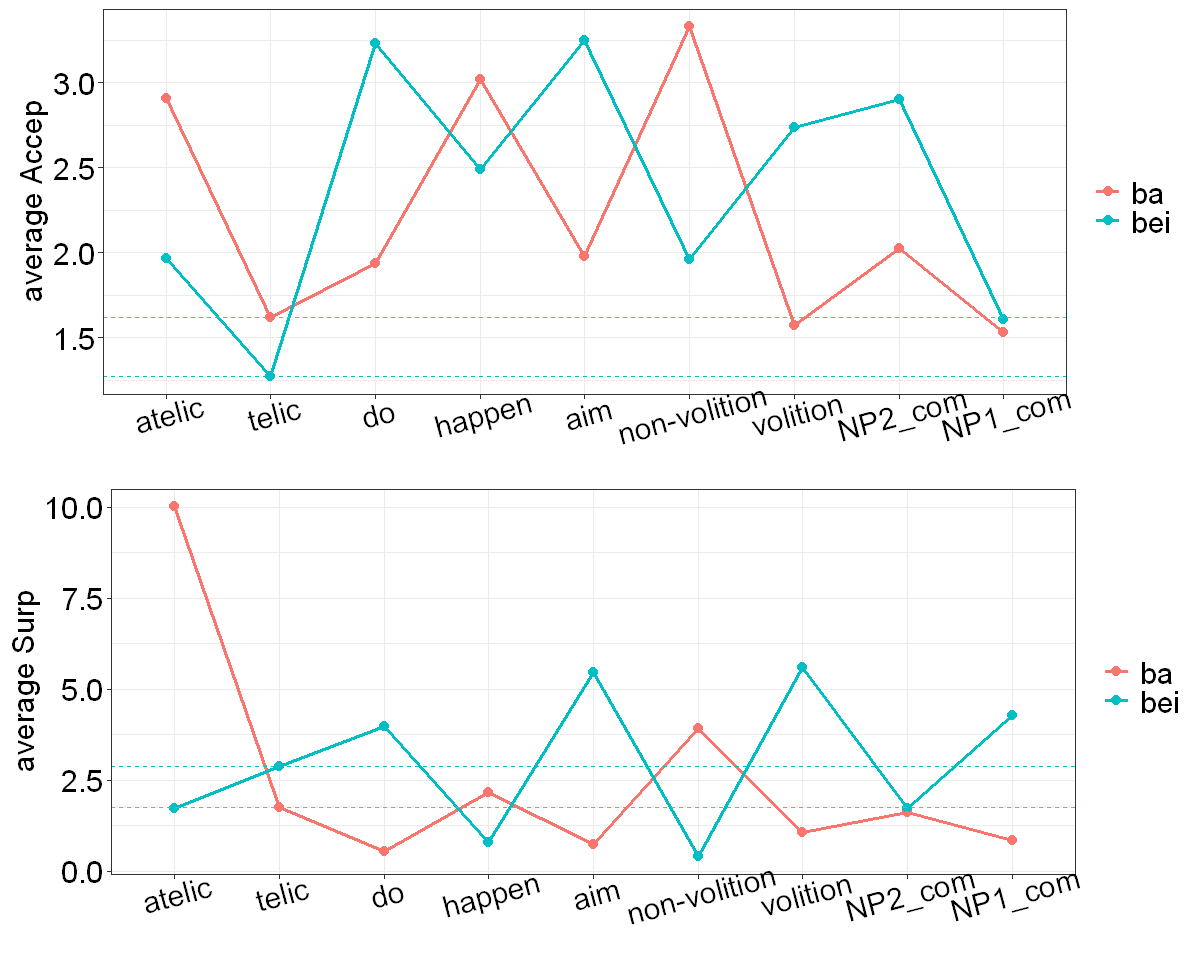

In [18]:
# plot data:
options(repr.plot.width=10, repr.plot.height=8)

p1 <- plot_fun(sum_hum_acc, condition_all,sum_hum_acc$BABEI)+ 
        geom_hline(data = sum_hum_acc %>% filter(Condition == "telic"), 
                   aes(yintercept = Mean, group = BABEI, color = BABEI), linetype="dashed") +
        labs(y = "average Accep") 

p2 <- plot_fun(sum_mod_surp, condition_all, sum_mod_surp$BABEI)+
        geom_hline(data = sum_mod_surp %>% filter(Condition == "telic"), 
                   aes(yintercept = Mean, group = BABEI, color = BABEI), linetype="dashed") +
        labs(y = "average Surp") 

ggarrange(p1,p2, ncol = 1, nrow = 2)

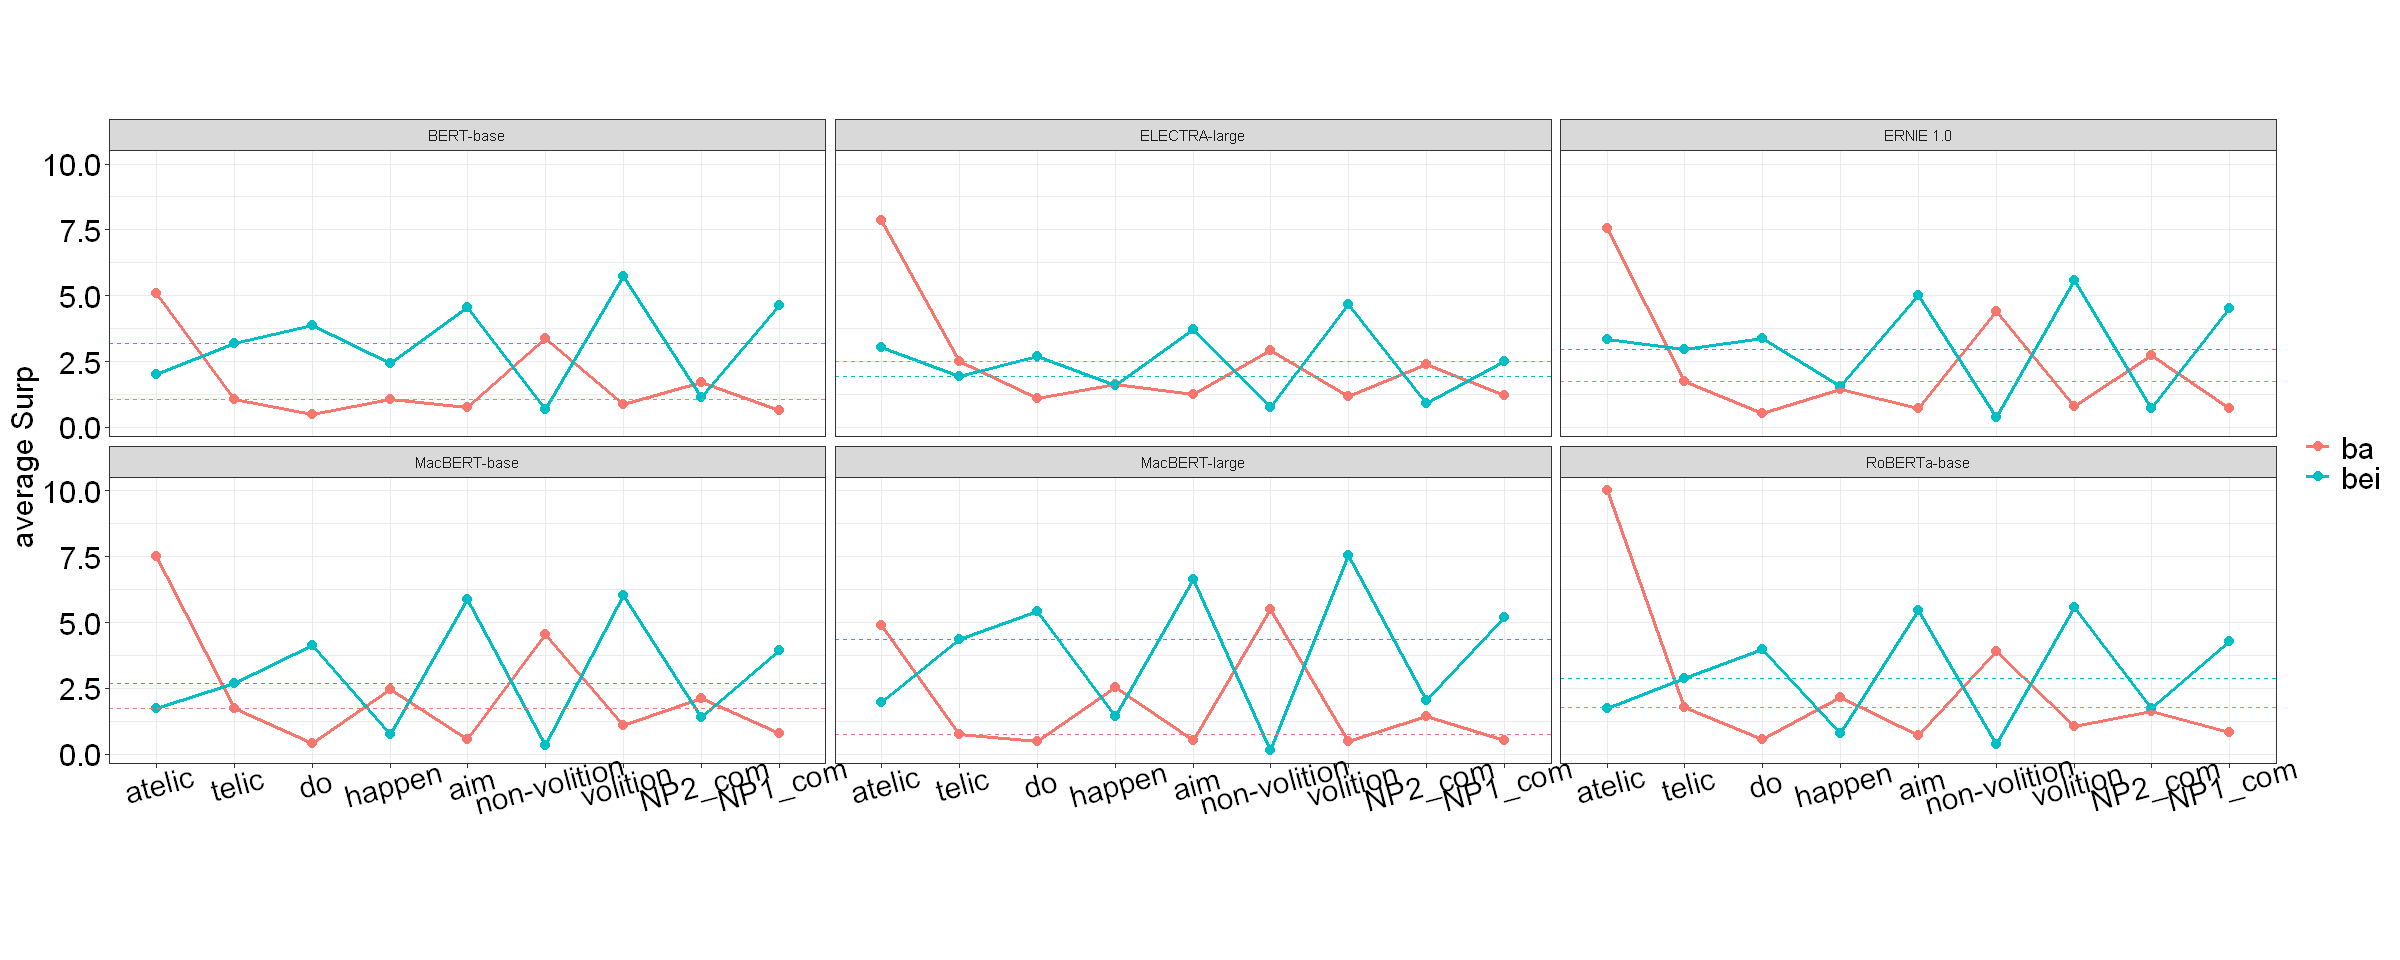

In [19]:
# plots for all language models (Figure 4 in Appendix):
mod_surp_all <- df_model %>% 
            group_by(Condition, model) %>% 
            summarize(ba = mean(ba), bei = mean(bei))%>% 
            gather(BABEI, Mean, ba:bei)


options(repr.plot.width=20, repr.plot.height = 8)

plot_fun(mod_surp_all, condition_all, mod_surp_all$BABEI)+ 
        facet_wrap(~ model) +
        geom_hline(data = mod_surp_all %>% filter(Condition == "telic"), 
                   aes(yintercept = Mean, group = BABEI, color = BABEI), linetype="dashed") +
        labs(y = "average Surp") 

# LMER results

In [23]:
# models' BA/BEI-preference for each condition (part of Table 3 in Appendix):
suppressMessages(res_mod_raw <- df_model %>% 
                        gather(BABEI, Value, ba:bei) %>% 
                        select(Verb,Condition, model, BABEI, Value) %>% 
                        group_by(Condition,model) %>% 
                        do(fun_lmer(.))
)

In [24]:
lmer_table(res_mod_raw,condition_all) %>%
        select(model_order) 

Condition,BERT-base,RoBERTa-base,ELECTRA-large,ERNIE 1.0,MacBERT-base,MacBERT-large
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
atelic,bei ***,bei **,bei *,bei *,bei *,bei ***
telic,ba ***,ba **,bei not_sig,ba **,ba *,ba ***
do,ba ***,ba ***,ba ***,ba ***,ba ***,ba ***
happen,ba ***,bei ***,bei not_sig,ba not_sig,bei ***,bei _marginal
aim,ba ***,ba ***,ba ***,ba ***,ba ***,ba ***
non-volition,bei ***,bei ***,bei ***,bei ***,bei ***,bei ***
volition,ba ***,ba ***,ba ***,ba ***,ba ***,ba ***
NP2_com,bei *,ba not_sig,bei ***,bei ***,bei not_sig,ba not_sig
NP1_com,ba ***,ba ***,ba ***,ba ***,ba ***,ba ***


In [25]:
# human BA/BEI-preference from human results for each condition(part of Table 3 in Appendix):
res_hum_raw <- df_hum %>% 
            group_by(Condition) %>% 
            do(fun_lmer(.)) %>% 
            mutate(model = 'human') # to fit "lmer-table" function

lmer_table(res_hum_raw,condition_all)

Condition,human
<chr>,<chr>
atelic,bei ***
telic,bei ***
do,ba ***
happen,bei ***
aim,ba ***
non-volition,bei ***
volition,ba ***
NP2_com,ba ***
NP1_com,ba not_sig


In [26]:
# BA/BEI-preference for telic condition (Tabel 1):
tel_hum_raw <- df_hum %>% 
            filter(Condition == "telic") %>%
            group_by(telic) %>%
            do(fun_lmer(.)) %>% 
            mutate(model = 'human') %>%
            rename(Condition = telic) # convient to fit 'lmer_table' function

lmer_table(tel_hum_raw, condition_tel)

Condition,human
<chr>,<chr>
temporal,bei ***
spatial,ba not_sig


In [27]:
suppressMessages(
    tel_mod_raw <- df_model %>%
            gather(BABEI, Value, ba:bei) %>%
            filter(Condition == "telic") %>%
            select(telic, Verb, model, BABEI, Value) %>%
            rename(Condition = telic) %>%
            group_by(Condition, model) %>%
            do(fun_lmer(.))
)

In [28]:
lmer_table(tel_mod_raw, condition_tel)%>%
        select(model_order) 

Condition,BERT-base,RoBERTa-base,ELECTRA-large,ERNIE 1.0,MacBERT-base,MacBERT-large
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
temporal,ba ***,bei not_sig,bei **,bei not_sig,bei not_sig,ba ***
spatial,ba ***,ba ***,ba **,ba ***,ba ***,ba ***


## Individuation (plot & LMER)

In [29]:
# read model results from the fold "furtherStudy_Individuation"
file.list <- list.files(path = "C:/Work/Mypaper_BABEI/Github/furtherStudy_Individuation", 
                        pattern='^Result_indi_', full.names = TRUE)
file.list2 <- setNames(file.list, file.list) # need an id-column with the file-names

suppressMessages(
    df_raw <- map_df(file.list2, read_excel, .id = "id")%>% 
        separate(id, c(NA, "model"), "Result_indi_")
)

In [30]:
# preprocess the data
df_ind <- df_raw %>% 
        mutate(model = recode(model,'bert_base.xlsx' = "BERT-base",
                         'roberta_base.xlsx' = 'RoBERTa-base',
                         'electra_large.xlsx'= 'ELECTRA-large',
                         'ernie.xlsx'        = 'ERNIE 1.0', 
                         'macbert_base.xlsx' = 'MacBERT-base', 
                         'macbert_large.xlsx' = 'MacBERT-large'),
          Condition = recode(Condition, 'NP1_com' = 'C_cl/P',
                                    'NP2_com' = 'P/C_cl',
                                    'NP1_2cha' = 'C/P',
                                    'NP1_4cha' = 'C_cl/C_cl',
                                    'telic' = 'P/P'))%>%
            select(-MaskedSentence) %>% 
            separate(Verb, c("telic", "Verb")) %>%
            mutate(ba = -log(df_raw$prob_ba+exp(-30), base = 2),
                   bei = -log(df_raw$prob_bei+exp(-30), base = 2)) %>%
            mutate(diff_babei = ba - bei, telic = case_when(telic == 's' ~ 'spatial',TRUE ~ 'temporal')) %>% 
            filter(Condition != "NP2_4cha" & Condition != "NP2_2cha" & telic == "spatial") %>% # 2 conditions not used in our results 
            select(-telic)

unique(df_ind$Condition)

[1] "P/C_cl"    "C_cl/P"    "C/P"       "C_cl/C_cl" "P/P"

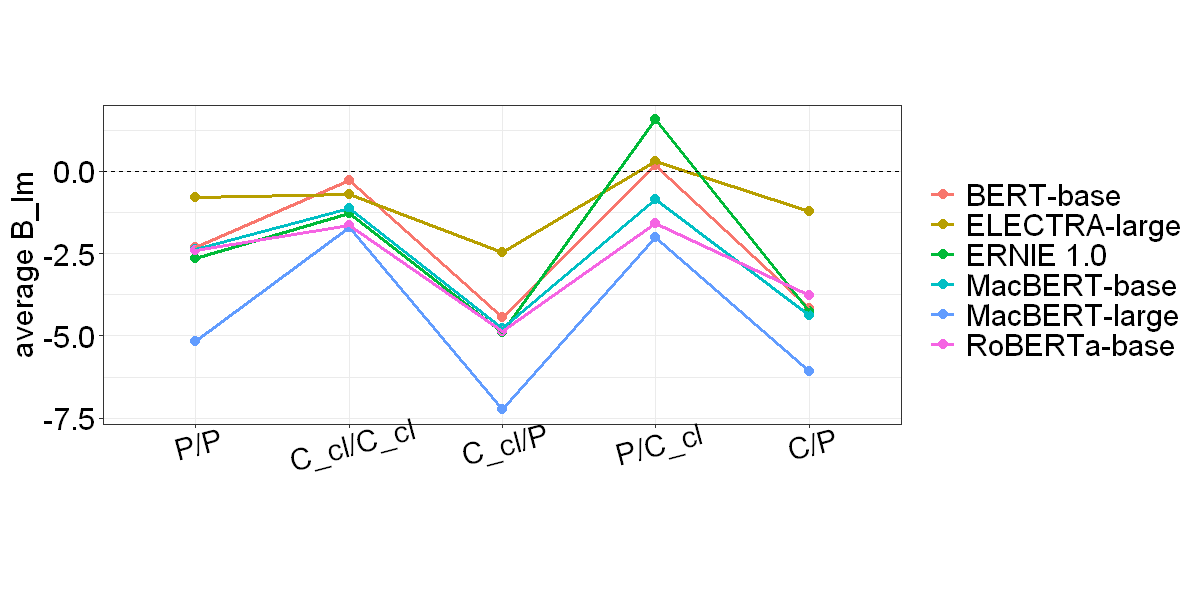

In [31]:
# plot Figure 3:
df_ind_plot <- df_ind %>% 
        group_by(Condition, model)%>% 
        summarise(Mean = mean(diff_babei))

options(repr.plot.width=10, repr.plot.height=5)
plot_fun(df_ind_plot, condition_ind, df_ind_plot$model) +
        geom_hline(aes(yintercept = 0), linetype="dashed")+
        ylab("average B_lm")

In [32]:
# BA/BEI-preference of each model (Tabel 4 in Appendix)
suppressMessages(
    res_ind_raw <- df_ind %>% 
            gather(BABEI, Value, ba:bei) %>% 
            select(Verb,Condition, model, BABEI, Value) %>% 
            group_by(Condition,model) %>% 
            do(fun_lmer(.))
)

In [33]:
lmer_table(res_ind_raw, condition_ind) %>%
        select(model_order)

Condition,BERT-base,RoBERTa-base,ELECTRA-large,ERNIE 1.0,MacBERT-base,MacBERT-large
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
P/P,ba ***,ba ***,ba **,ba ***,ba ***,ba ***
C_cl/C_cl,ba not_sig,ba **,ba **,ba _marginal,ba *,ba *
C_cl/P,ba ***,ba ***,ba ***,ba ***,ba ***,ba ***
P/C_cl,bei not_sig,ba **,bei not_sig,bei **,ba *,ba **
C/P,ba ***,ba ***,ba *,ba ***,ba ***,ba ***
